<a href="https://colab.research.google.com/github/SavioAndres/Classificacao-de-Documentos-SEFAZ-SE/blob/master/classificacao_acervo_sefaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspellchecker

In [ ]:
import pandas as pd
import re
from unicodedata import normalize
from spellchecker import SpellChecker
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from imblearn.over_sampling import BorderlineSMOTE

# Processamento da base

## Caracterização da base

In [3]:
df = pd.read_csv('/content/drive/MyDrive/TCC/dataset2.csv', encoding='utf8')
df.head()

,tipo,score,caminho,nome,data,protocolo,ci,texto
0,PORTARIA OUTRAS,1.0,00 DOCUMENTO DE TODOS/2021.04.01,Portaria Outras 16179798396210.jpg.txt,2021.04.01,NaN,NaN,PORVIR *\n\nSECRETARIADEESTADODA — «fiiip SERG...
1,PORTARIA OUTRAS,1.0,00 DOCUMENTO DE TODOS/2021.04.01,Portaria Outras 16179798396471.jpg.txt,2021.04.01,NaN,NaN,SECRETARIA DE ESTADO DA 3 SERGIPE\nFAZENDA Set...
2,PORTARIA OUTRAS,1.0,00 DOCUMENTO DE TODOS/2021.04.01,Portaria Outras 16179798396552.jpg.txt,2021.04.01,NaN,NaN,SECRETARIA DE ESTADO DA\n\nFAZENDA\n\n \n\nPOR...
3,PORTARIA OUTRAS,1.0,00 DOCUMENTO DE TODOS/2021.04.01,Portaria Outras 16179798396723.jpg.txt,2021.04.01,NaN,NaN,V\nAN\n\nSECRETARIA DE ESTADO DA\n\nFAZENDA\n\...
4,PORTARIA OUTRAS,1.0,00 DOCUMENTO DE TODOS/2021.04.01,Portaria Outras 16179798396854.jpg.txt,2021.04.01,NaN,NaN,SECRETARIA DE ESTADO DA\n\nFAZENDA\n\nSERGIPE\...


In [4]:
# Agrupa as páginas por documento separadamente pelo tipo
df = df.groupby(['caminho', 'tipo']).agg(list).reset_index()
# Remove as colunas desnecessárias
df.drop(columns=['score', 'caminho', 'nome', 'data', 'protocolo', 'ci'], inplace=True)
# Junta todas as páginas do documento é uma única célula
df['texto'] = df.apply(lambda row: ' '.join(row.texto), axis='columns')
df.head()

,tipo,texto
0,PORTARIA OUTRAS,PORVIR *\n\nSECRETARIADEESTADODA — «fiiip SERG...
1,INCORPORACAO FUNCAO,"\n\nGOVERNO\nDE\nSERGIPE\n\n914,.000-03751..."
2,AVERBACAO TEMPO SERVICO,\n\n \n \n\nª\n\nESTADO DE SERGIPE\nSEC...
3,AVERBACAO TEMPO SERVICO,"4h.10\n\nM\n\nREQUERIMENTO\n\nEu, Abílio Casta..."
4,AVERBACAO TEMPO SERVICO,"7 "" :\nLA : : ç)/\nJc SERGIPE Ó\ndA DE ESTADO ..."


In [5]:
df['tipo'].value_counts()

OUTROS                                       1387
FERIAS                                       1279
PORTARIA CONCESSAO LICENCA PREMIO             286
LICENCA MEDICA                                286
PORTARIA REMOCAO                              263
AVERBACAO TEMPO SERVICO                       252
GOZO LICENCA PREMIO                           243
CONCESSAO LICENCA PREMIO                      218
PORTARIA OUTRAS                               164
PORTARIA DESIGNACAO                           148
PORTARIA CONCESSAO LICENCA MEDICA              83
CHECKLIST DOCUMENTOS                           78
ABONO PERMANENCIA                              54
PORTARIA DISPENSA                              54
PROGRESSAO POR TITULACAO                       52
MAJORACAO LICENCA PREMIO                       22
PORTARIA LOTAR                                 22
PORTARIA CUMPRIMENTO                           14
INCORPORACAO FUNCAO                            14
ABONO FALTAS                                   10


## Pré-processamento de texto

In [6]:
# Corretor ortográfico
spell = SpellChecker(language=None, distance=1)
spell.word_frequency.load_dictionary('/content/drive/MyDrive/TCC/dictionary_not_accented.json')

def spell_checker(text):
  # encontrar palavras que podem ter erros ortográficos
  misspelled = spell.unknown(text.split())
  text = ' ' + text + ' '
  for word in misspelled:
    text = re.sub(' ' + word + ' ', ' ' + spell.correction(word) + ' ', text)
  text = text[1:]
  return text[:-1]

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.remove('se')
stemmer = SnowballStemmer("portuguese")

def _normalize(text):
  # Traforma todas as letras do texto em minúsculas
  text = text.lower()
  # Remove acentuações das palavras
  text = normalize('NFKD', text).encode('ASCII','ignore').decode('ASCII')
  # Remoção de Non Letters
  text = re.sub('[^a-z \\\]', ' ', text)
  # Substitui todas as letras que estão repetidas consecutivamento por uma letra
  text = re.sub(r'([^rso])(?=\1+)|(rr)(?=r+)|(ss)(?=s+)|(oo)(?=o+)', '', ' ' + text + ' ')
  # Duplica os espaços para remover palavras com letras únicas e vizinhas únicas
  text = re.sub(' ', '  ', text)
  text = re.sub('\s\w\s|\s\w\w\s', ' ', text)
  # Corretor ortográfico
  text = spell_checker(text)
  # Elimina todos stopwords e extraindo o radical das palavras - stemmer.stem(word)
  text = [word for word in text.split() if word not in stopwords]
  # Remove todos os espaços demasiados no texto
  return ' '.join(text)

In [8]:
# Mapeamento dos labels em valores numéricos
dict_tipos = dict()
dict_tipos_ = dict()
for i, x in enumerate(df['tipo'].value_counts().index, -1):
  dict_tipos[x] = i
  dict_tipos_[i] = x

In [9]:
# Aplicando pré-processamento à base
df['tipo'] = df['tipo'].map(dict_tipos).astype(int)
df['texto'] = df['texto'].map(_normalize)
df.head(3)

,tipo,texto
0,7,porvir secretariadestadoda fim sergipe fazenda...
1,17,governo sergipe requerimento autoridade dirigi...
2,4,estado sergipe secretaria estado fazenda sefaz...


### Vetorização do texto

In [10]:
# Vetorização do texto com TFIDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=220, 
                                   min_df=0.2, use_idf=True, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(list(df['texto']))

CPU times: user 11 s, sys: 366 ms, total: 11.4 s
Wall time: 11.4 s


## Balanceamento semi-supervisionado

### Rotulagem de dados

In [ ]:
# Label Propagation
label_prop_propagation = LabelPropagation(n_neighbors=7, max_iter=2000, tol=0.01)
label_prop_propagation.fit(tfidf_matrix.toarray(), df['tipo'].values)

In [12]:
# Label Spreading
label_prop_spreading = LabelSpreading(n_neighbors=7, max_iter=2000, tol=0.01)
label_prop_spreading.fit(tfidf_matrix.toarray(), df['tipo'].values)

LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=2000, n_jobs=None,
               n_neighbors=7, tol=0.01)

In [13]:
# Dataframe com vetorização e TFIDF aplicados
df2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
df2['label'] = df['tipo'].values
df2.head()

,adm,administracao,administrativo,ana,ano,apos,aquisitivo,aracaju,art,artigo,assinatura,assunto,atenciosamente,atribuicoes,auditor,augusto,augusto franco,cargo,cargo funcao,centro,cep,certidao,cod,comunicacao,conforme,conformidade,cpf,daf,data,decreto,desenvolvimento,desenvolvimento pessoas,dezembro,dia,dias,doc,documento,emissao,entrara,entrara gozo,...,sal,salvio,santos,sao,saude,sec,sec estado,sec estado fazenda,secretaria estado,secretaria estado fazenda,secretario,sefaz,senhor,senhoria,sergipe secretaria,sergipe secretaria estado,servico,servidor,silva,sipes,sipes sistema,sipes sistema integrado,sistema,sistema integrado,sistema integrado pessoal,ssp,tancredo,tancredo neves,tecnico,tel,telefax,tempo,termos,trabalho,tributos,unidade,uso,vossa,vossa senhoria,label
0,0.000000,0.007729,0.000000,0.030819,0.000000,0.000000,0.000000,0.005016,0.073551,0.000000,0.000000,0.000000,0.000000,0.009427,0.008165,0.042571,0.000000,0.013487,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.008893,0.0,0.006766,0.000000,0.006588,0.000000,0.0,0.0,0.051206,0.000000,0.052112,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.009103,0.595693,0.009043,0.000000,0.000000,0.00000,0.000000,0.051888,0.052067,0.017389,0.006893,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.275033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028217,0.000000,0.000000,0.000000,0.008308,0.000000,0.0,7
1,0.030898,0.063838,0.017789,0.113636,0.376392,0.010289,0.004678,0.044390,0.043392,0.041631,0.000000,0.004536,0.000000,0.022246,0.091526,0.025115,0.026636,0.230741,0.025587,0.029877,0.020629,0.000000,0.031086,0.0,0.020986,0.0,0.075837,0.036588,0.062189,0.014891,0.0,0.0,0.008631,0.035708,0.021960,0.004756,0.000000,0.010228,0.0,0.0,...,0.022163,0.037594,0.000000,0.096024,0.000000,0.110448,0.10314,0.096759,0.050091,0.033789,0.020517,0.000000,0.000000,0.0,0.033066,0.033319,0.086824,0.134180,0.000000,0.097393,0.101323,0.096295,0.096308,0.095655,0.095923,0.037122,0.032212,0.027006,0.096214,0.049700,0.039644,0.090062,0.022196,0.021080,0.127725,0.004814,0.039212,0.004379,0.0,17
2,0.000000,0.041162,0.040146,0.041032,0.000000,0.000000,0.000000,0.026714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035912,0.046195,0.000000,0.000000,0.551199,0.000000,0.0,0.000000,0.0,0.036030,0.000000,0.035086,0.000000,0.0,0.0,0.000000,0.000000,0.039646,0.000000,0.044066,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.102130,0.000000,0.00000,0.000000,0.050242,0.027728,0.000000,0.073416,0.000000,0.0,0.029849,0.030077,0.368830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254060,0.050090,0.142720,0.000000,0.043458,0.000000,0.000000,0.0,4
3,0.006214,0.077030,0.018782,0.057590,0.071958,0.007243,0.000000,0.070822,0.018326,0.036629,0.046017,0.012772,0.006675,0.000000,0.000000,0.021213,0.022498,0.095208,0.064838,0.028040,0.023233,0.398540,0.021881,0.0,0.073860,0.0,0.005619,0.014717,0.114906,0.000000,0.0,0.0,0.012151,0.080429,0.309142,0.020086,0.082465,0.071994,0.0,0.0,...,0.054600,0.022681,0.017060,0.112649,0.047782,0.028793,0.00660,0.006811,0.109693,0.077836,0.036105,0.005725,0.015976,0.0,0.041894,0.042214,0.366684,0.015316,0.000000,0.000000,0.000000,0.000000,0.028543,0.000000,0.000000,0.022396,0.000000,0.000000,0.000000,0.027987,0.023918,0.483372,0.046870,0.089029,0.043154,0.081327,0.000000,0.006164,0.0,4
4,0.110724,0.009532,0.009297,0.000000,0.000000,0.000000,0.000000,0.055676,0.045353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084001,0.089089,0.141377,0.032093,0.093685,0.077623,0.023208,0.032492,0.0,0.000000,0.0,0.000000,0.087412,0.625630,0.000000,0.0,0.0,0.000000,0.074644,0.376423,0.000000,0.000000,0.010691,0.0,0.0,...,0.023165,0.089814,0.000000,0.066910,0.011825,0.000000,0.00000,0.000000,0.029087,0.032106,0.000000,0.229517,0.000000,0.0,0.020737,0.020895,0.149470,0.045485,0.000000,0.000000

In [14]:
X = tfidf_matrix.toarray()
# Verificando divergências entre os resultados da rotulagem na classe OUTROS
df_outros = df2[df2['label'] == -1]
list_divergent_pred_indexes = list()
for i in df_outros.index:
  pred = label_prop_propagation.predict(X[[i]])[0]
  pred2 = label_prop_spreading.predict(X[[i]])[0]
  if pred != pred2:
    list_divergent_pred_indexes.append(i)
print(len(list_divergent_pred_indexes), 
      'Resultados divergentes entre as rotulagens na classe OUTROS')

# Verificando divergências entre os resultados da 
# rotulagem nas classes com supervisão
list_divergent_ranked_indixes = list()
for i, x in enumerate(df2['label'].values):
  if x != -1:
    pred = label_prop_propagation.predict(X[[i]])[0]
    pred2 = label_prop_spreading.predict(X[[i]])[0]
    if x != pred or x != pred2:
      list_divergent_ranked_indixes.append(i)
print(len(list_divergent_ranked_indixes),
      'Resultados divergentes entre as rotulagens dos dados classificados manualmente')

424 Resultados divergentes entre as rotulagens na classe OUTROS
218 Resultados divergentes entre as rotulagens dos dados classificados manualmente


In [15]:
# Remove os documentos classificados de forma divergentes entre os algoritmos na classe OUTROS
df2.drop(df2.loc[list_divergent_pred_indexes].index, inplace = True)
# Remove documentos já classificados, mas que pode está classificado de forma errada
df2.drop(df2.loc[list_divergent_ranked_indixes].index, inplace = True)

In [ ]:
# Espalha os dados da classe OUTROS nas outras classes com menos de 100 documentos
for i in df2[df2['label'] == -1].index:
  pred = label_prop_propagation.predict(X[[i]])[0]
  if len(df2[df2['label'] == pred]) < 100:
    df2['label'][i] = pred

### Redução da base

In [17]:
def reduce_database(df_, amount = 100):
  labels_quantities = df2['label'].value_counts()
  tipos = [x for x in labels_quantities.index if labels_quantities[x] > amount]

  for tipo in tipos:
    df_extra = df_[df_['label'] == tipo]
    df_ = df_.drop(df_extra.index)
    df_ = df_.append(df_extra.sample(amount, random_state=1))
  return df_

In [18]:
# Redução da base para no máximo 100 documentos por classe
df2 = reduce_database(df2, amount=100)
# Remoção da classe OUTROS
df2.drop(df2[df2['label'] == -1].index, inplace = True)

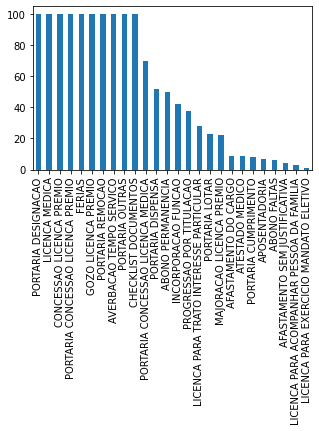

In [19]:
# Plotagem da quantidade de documentos por classe
df2['label'].map(dict_tipos_).astype(object).value_counts().plot(kind='bar', figsize=(5, 3))

### Geração de dados sintéticos

In [ ]:
unlabeled_data = df2.drop(columns=['label'])

# Borderline SMOTE
oversample = BorderlineSMOTE(random_state=1)
X, y = oversample.fit_resample(unlabeled_data.to_numpy(), df2['label'])

In [21]:
# Gerando novo dataframe com os novos dados sintéticos
df2 = pd.DataFrame(X, columns=tfidf_vectorizer.get_feature_names())
df2['label'] = y
df2['label'] = df2['label'].map(dict_tipos_).astype(str)
df2['label'].value_counts()

PORTARIA CONCESSAO LICENCA MEDICA            100
CHECKLIST DOCUMENTOS                         100
APOSENTADORIA                                100
CONCESSAO LICENCA PREMIO                     100
PORTARIA CONCESSAO LICENCA PREMIO            100
GOZO LICENCA PREMIO                          100
AVERBACAO TEMPO SERVICO                      100
ATESTADO MEDICO                              100
PORTARIA LOTAR                               100
PORTARIA OUTRAS                              100
LICENCA PARA TRATO INTERESSE PARTICULAR      100
PROGRESSAO POR TITULACAO                     100
PORTARIA DESIGNACAO                          100
ABONO PERMANENCIA                            100
LICENCA MEDICA                               100
MAJORACAO LICENCA PREMIO                     100
PORTARIA REMOCAO                             100
FERIAS                                       100
PORTARIA CUMPRIMENTO                         100
PORTARIA DISPENSA                            100
INCORPORACAO FUNCAO 

In [22]:
# Remoção das classes que não atingiram 100 documentos
df2.drop(df2[df2['label'] == 'AFASTAMENTO DO CARGO'].index, inplace = True)
df2.drop(df2[df2['label'] == 'ABONO FALTAS'].index, inplace = True)
df2.drop(df2[df2['label'] == 'LICENCA PARA ACOMPANHAR PESSOA DA FAMILIA'].index, inplace = True)
df2.drop(df2[df2['label'] == 'AFASTAMENTO SEM JUSTIFICATIVA'].index, inplace = True)
df2.drop(df2[df2['label'] == 'LICENCA PARA EXERCICIO MANDATO ELETIVO'].index, inplace = True)

## Salvando base em disco

In [23]:
df2.to_csv('/content/drive/MyDrive/TCC/base processada/pre-processed_data.csv', index=False)

# Modelos de machine learning

In [24]:
# Obtendo base em disco
df = pd.read_csv('/content/drive/MyDrive/TCC/base processada/pre-processed_data.csv')
df.head()

,adm,administracao,administrativo,ana,ano,apos,aquisitivo,aracaju,art,artigo,assinatura,assunto,atenciosamente,atribuicoes,auditor,augusto,augusto franco,cargo,cargo funcao,centro,cep,certidao,cod,comunicacao,conforme,conformidade,cpf,daf,data,decreto,desenvolvimento,desenvolvimento pessoas,dezembro,dia,dias,doc,documento,emissao,entrara,entrara gozo,...,sal,salvio,santos,sao,saude,sec,sec estado,sec estado fazenda,secretaria estado,secretaria estado fazenda,secretario,sefaz,senhor,senhoria,sergipe secretaria,sergipe secretaria estado,servico,servidor,silva,sipes,sipes sistema,sipes sistema integrado,sistema,sistema integrado,sistema integrado pessoal,ssp,tancredo,tancredo neves,tecnico,tel,telefax,tempo,termos,trabalho,tributos,unidade,uso,vossa,vossa senhoria,label
0,0.030898,0.063838,0.017789,0.113636,0.376392,0.010289,0.004678,0.044390,0.043392,0.041631,0.000000,0.004536,0.0,0.022246,0.091526,0.025115,0.026636,0.230741,0.025587,0.029877,0.020629,0.000000,0.031086,0.0,0.020986,0.0,0.075837,0.036588,0.062189,0.014891,0.000000,0.000000,0.008631,0.035708,0.021960,0.004756,0.000000,0.010228,0.000000,0.0,...,0.022163,0.037594,0.000000,0.096024,0.000000,0.110448,0.103140,0.096759,0.050091,0.033789,0.020517,0.000000,0.0,0.0,0.033066,0.033319,0.086824,0.134180,0.000000,0.097393,0.101323,0.096295,0.096308,0.095655,0.095923,0.037122,0.032212,0.027006,0.096214,0.049700,0.039644,0.090062,0.022196,0.021080,0.127725,0.004814,0.039212,0.004379,0.0,INCORPORACAO FUNCAO
1,0.120314,0.036251,0.015153,0.005162,0.100274,0.017529,0.000000,0.043693,0.354827,0.059103,0.000000,0.025760,0.0,0.000000,0.005471,0.051343,0.054453,0.103921,0.029061,0.050899,0.046859,0.075654,0.035306,0.0,0.029794,0.0,0.000000,0.059364,0.498827,0.000000,0.005943,0.006242,0.000000,0.040555,0.234442,0.010803,0.022177,0.011617,0.000000,0.0,...,0.031464,0.067095,0.004588,0.054529,0.102797,0.023230,0.000000,0.000000,0.028445,0.027909,0.005826,0.138553,0.0,0.0,0.011266,0.011352,0.237824,0.024712,0.011518,0.000000,0.000000,0.000000,0.005757,0.000000,0.000000,0.078298,0.054876,0.055209,0.017254,0.067736,0.057890,0.236539,0.075626,0.041898,0.000000,0.027338,0.000000,0.000000,0.0,APOSENTADORIA
2,0.000000,0.234195,0.000000,0.133403,0.068189,0.000000,0.000000,0.065139,0.000000,0.000000,0.159893,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121089,0.040729,0.342132,0.0,0.076991,0.0,0.146428,0.000000,0.199628,0.036420,0.000000,0.000000,0.000000,0.026200,0.000000,0.104688,0.035817,0.075046,0.000000,0.0,...,0.040653,0.000000,0.000000,0.352275,0.000000,0.090042,0.034398,0.035497,0.142928,0.000000,0.000000,0.029836,0.0,0.0,0.145568,0.146679,0.074947,0.159650,0.037203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155639,0.000000,0.000000,0.000000,0.145865,0.000000,0.000000,0.000000,0.077336,0.000000,0.000000,0.071926,0.000000,0.0,CHECKLIST DOCUMENTOS
3,0.000000,0.000000,0.013748,0.042153,0.373473,0.015904,0.000000,0.045740,0.026827,0.000000,0.000000,0.028046,0.0,0.000000,0.119127,0.000000,0.000000,0.221360,0.000000,0.015393,0.025508,0.017159,0.000000,0.0,0.064874,0.0,0.123383,0.032315,0.024030,0.015344,0.032348,0.033978,0.013340,0.011038,0.000000,0.000000,0.015090,0.031617,0.000000,0.0,...,0.000000,0.000000,0.000000,0.016491,0.000000,0.088516,0.086953,0.089731,0.094626,0.047476,0.000000,0.050281,0.0,0.0,0.071550,0.072097,0.015788,0.145734,0.000000,0.110918,0.098909,0.066149,0.094014,0.065709,0.049420,0.000000,0.016596,0.016696,0.125229,0.015364,0.000000,0.017400,0.000000,0.000000,0.126345,0.000000,0.000000,0.000000,0.0,INCORPORACAO FUNCAO
4,0.000000,0.000000,0.000000,0.063334,0.064746,0.000000,0.000000,0.206168,0.000000,0.000000,0.151820,0.063207,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114975,0.000000,0.721904,0.0,0.000000,0.0,0.055614,0.000000,0.162470,0.000000,0.000000,0.000000,0.000000,0.049753,0.000000,0.265071,0.000000,0.142514,0.072093,0.0,...,0.154402,0.000000,0.000000,0.297322,0.000000,0.170991,0.000000,0.000000,0